# Analyzing cancer gene comutation dependencies

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from collections import Counter
from itertools import combinations
from math import ceil
from time import time
from typing import Collection

import arviz as az
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from adjustText import adjust_text

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.analysis.sublineage_model_analysis import (
    load_sublineage_model_posteriors,
    sublineage_to_lineage_map,
)
from speclet.io import notebook_output_and_stash_dirs
from speclet.managers.posterior_data_manager import PosteriorDataManager as PostDataMan
from speclet.plot import align_legend_title, set_speclet_theme
from speclet.plot.color_pal import (
    lineage_color_pal,
    pal_to_legend_handles,
    sublineage_color_pal,
)
from speclet.project_configuration import arviz_config
from speclet.string_functions import str_hash

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"

# Constants
RANDOM_SEED = 709
np.random.seed(RANDOM_SEED)
arviz_config()

In [5]:
OUTPUT_DIR, STASH_DIR = notebook_output_and_stash_dirs(
    "100_120_cancer-gene-comut-analysis"
)

### Data

#### Model posteriors

In [6]:
postmen = load_sublineage_model_posteriors()

In [7]:
postmen.keys

['bile duct (cholangiocarcinoma)',
 'bile duct (gallbladder adenocarcinoma)',
 'blood (ALL)',
 'blood (AML)',
 'blood (CLL)',
 'blood (CML)',
 'bone (Ewing sarcoma)',
 'bone (chordoma)',
 'bone (osteosarcoma)',
 'breast',
 'central nervous system (glioma)',
 'central nervous system (medulloblastoma)',
 'cervix (cervical carcinoma)',
 'cervix (cervical squamous)',
 'colorectal',
 'esophagus (esophagus adenocarcinoma)',
 'esophagus (esophagus squamous)',
 'eye (uveal melanoma)',
 'gastric (gastric adenocarcinoma)',
 'kidney (renal cell carcinoma)',
 'liver (hepatocellular carcinoma)',
 'lung (NSCLC)',
 'lung (SCLC)',
 'lung (mesothelioma)',
 'lymphocyte (hodgkin lymphoma)',
 'lymphocyte (lymphoma unspecified)',
 'lymphocyte (non hodgkin lymphoma)',
 'ovary (ovary adenocarcinoma)',
 'pancreas',
 'peripheral nervous system (neuroblastoma)',
 'plasma cell (multiple myeloma)',
 'prostate',
 'skin (melanoma)',
 'skin (skin squamous)',
 'soft tissue (ATRT)',
 'soft tissue (liposarcoma)',
 'sof

In [8]:
len(postmen)

43

In [9]:
sub_to_lineage, lineages = sublineage_to_lineage_map(postmen)

In [10]:
sublineage_pal = sublineage_color_pal()
lineage_pal = lineage_color_pal()

## Analysis

### Gather cancer gene comutation posteriors

In [11]:
def get_cancer_genes(pm: PostDataMan, stash: bool = True) -> list[str]:
    stash_fp = STASH_DIR / f"cancer-genes_{pm.id}.json"
    if stash and stash_fp.exists():
        with open(stash_fp, "r") as fp:
            return json.load(fp)

    try:
        cg_coords = pm.trace.posterior.coords.get("cancer_gene")
    except AssertionError:
        print(f"Skipping {pm.id}")
        cg_coords = None

    if cg_coords is None:
        cancer_genes = []
    else:
        cancer_genes = list(cg_coords.values)
        cancer_genes.sort()

    with open(stash_fp, "w") as fp:
        json.dump(cancer_genes, fp)

    return cancer_genes

In [12]:
def _zero_in_hdi(low: float, high: float) -> bool:
    return low <= 0 <= high


zero_in_hdi = np.vectorize(_zero_in_hdi)

In [13]:
def get_variable_posterior_summary(
    pm: PostDataMan, var_name: str, stash: bool = True
) -> pd.DataFrame:
    stash_fp = STASH_DIR / f"post-summary-df_{pm.id}-{var_name}-post.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)

    try:
        post = pm.posterior_summary.copy().query(f"var_name == '{var_name}'")
    except FileNotFoundError:
        print(f"Skipping {pm.id}")
        return pd.DataFrame()

    if len(post) > 0:
        post = post.reset_index(drop=True).assign(lineage_subtype=pm.id)

    post.to_csv(stash_fp, index=False)
    return post


def get_cancer_gene_comut_parameters(
    pm: PostDataMan, stash: bool = True
) -> pd.DataFrame:
    res = get_variable_posterior_summary(pm, "h", stash=stash)
    if len(res) == 0:
        return res

    res = res.pipe(
        extract_coords_param_names,
        col="parameter",
        names=["hugo_symbol", "cancer_gene"],
    ).assign(hdi_zero=lambda d: zero_in_hdi(d["hdi_5.5%"], d["hdi_94.5%"]))
    return res


def get_mu_a_parameters(pm: PostDataMan, stash: bool = True) -> pd.DataFrame:
    return (
        get_variable_posterior_summary(pm, "mu_a", stash=stash)
        .pipe(
            extract_coords_param_names,
            col="parameter",
            names=["hugo_symbol"],
        )
        .assign(hdi_zero=lambda d: zero_in_hdi(d["hdi_5.5%"], d["hdi_94.5%"]))
    )


def get_synthetic_lethal_posterior_parameters(
    pm: PostDataMan, stash: bool = True
) -> pd.DataFrame:
    h_post = get_cancer_gene_comut_parameters(pm, stash=stash)
    if len(h_post) == 0:
        return pd.DataFrame()

    h_post = h_post[
        [
            "hugo_symbol",
            "cancer_gene",
            "mean",
            "sd",
            "hdi_5.5%",
            "hdi_94.5%",
            "hdi_zero",
        ]
    ]

    mu_a_post = get_mu_a_parameters(pm, stash=stash)[
        ["hugo_symbol", "mean", "sd", "hdi_5.5%", "hdi_94.5%", "hdi_zero"]
    ]

    res = h_post.merge(mu_a_post, on=["hugo_symbol"], suffixes=("_h", "_mu_a")).assign(
        lineage_subtype=pm.id
    )
    return res

In [14]:
synlet_post = (
    pd.concat(
        [
            get_synthetic_lethal_posterior_parameters(pm, stash=False)
            for pm in postmen.posteriors
        ]
    )
    .reset_index(drop=True)
    .assign(
        lineage=lambda d: d["lineage_subtype"].map(sub_to_lineage),
    )
)
synlet_post.to_csv(OUTPUT_DIR / "synthetic-lethal-posterior.csv", index=False)
synlet_post.head()

hugo_symbol cancer_gene  mean_h   sd_h  hdi_5.5%_h  hdi_94.5%_h  hdi_zero_h  \
0        A1BG        BRAF   0.014  0.009      -0.001        0.028        True   
1        A1CF        BRAF   0.015  0.009       0.001        0.030       False   
2         A2M        BRAF   0.009  0.009      -0.006        0.023        True   
3       A2ML1        BRAF   0.015  0.009      -0.001        0.029        True   
4     A3GALT2        BRAF  -0.001  0.010      -0.017        0.014        True   

   mean_mu_a  sd_mu_a  hdi_5.5%_mu_a  hdi_94.5%_mu_a  hdi_zero_mu_a  \
0      0.322    0.122          0.134           0.522          False   
1      0.268    0.122          0.064           0.455          False   
2      0.176    0.123         -0.025           0.365           True   
3      0.320    0.125          0.122           0.525          False   
4      0.114    0.124         -0.087           0.308           True   

                  lineage_subtype    lineage  
0  bile duct (cholangiocarcinoma)  bile duct  
1  bile duct (cholangiocarcinoma)  bile duct  
2  bile duct (cholangiocarcinoma)  bile duct  
3  bile duct (cholangiocarcinoma)  bile duct  
4  bile duct (cholangiocarcinoma)  bile duct

In [15]:
synlet_post.query("not hdi_zero_h").groupby(["lineage_subtype", "lineage"])[
    "hugo_symbol"
].count().reset_index(drop=False)

lineage_subtype                    lineage  \
0              bile duct (cholangiocarcinoma)                  bile duct   
1                                 blood (ALL)                      blood   
2                                 blood (AML)                      blood   
3                                      breast                     breast   
4             central nervous system (glioma)     central nervous system   
5    central nervous system (medulloblastoma)     central nervous system   
6                                  colorectal                 colorectal   
7              esophagus (esophagus squamous)                  esophagus   
8            gastric (gastric adenocarcinoma)                    gastric   
9               kidney (renal cell carcinoma)                     kidney   
10           liver (hepatocellular carcinoma)                      liver   
11                               lung (NSCLC)                       lung   
12                                lung (SCLC)                       lung   
13               ovary (ovary adenocarcinoma)                      ovary   
14                                   pancreas                   pancreas   
15  peripheral nervous system (neuroblastoma)  peripheral nervous system   
16                            skin (melanoma)                       skin   
17                              urinary tract              urinary tract   
18        uterus (endometrial adenocarcinoma)                     uterus   

    hugo_symbol  
0          3196  
1         51784  
2         11058  
3         14138  
4         40161  
5           243  
6          9831  
7          4235  
8         27789  
9         11959  
10         1883  
11        32159  
12         9345  
13        14732  
14        13545  
15         5157  
16        35023  
17        12482  
18        44671

In [16]:
synlet_post.query("not hdi_zero_h and hdi_zero_mu_a").groupby(
    ["lineage_subtype", "lineage"]
)["hugo_symbol"].count().reset_index(drop=False)

lineage_subtype                    lineage  \
0              bile duct (cholangiocarcinoma)                  bile duct   
1                                 blood (ALL)                      blood   
2                                 blood (AML)                      blood   
3                                      breast                     breast   
4             central nervous system (glioma)     central nervous system   
5    central nervous system (medulloblastoma)     central nervous system   
6                                  colorectal                 colorectal   
7              esophagus (esophagus squamous)                  esophagus   
8            gastric (gastric adenocarcinoma)                    gastric   
9               kidney (renal cell carcinoma)                     kidney   
10           liver (hepatocellular carcinoma)                      liver   
11                               lung (NSCLC)                       lung   
12                                lung (SCLC)                       lung   
13               ovary (ovary adenocarcinoma)                      ovary   
14                                   pancreas                   pancreas   
15  peripheral nervous system (neuroblastoma)  peripheral nervous system   
16                            skin (melanoma)                       skin   
17                              urinary tract              urinary tract   
18        uterus (endometrial adenocarcinoma)                     uterus   

    hugo_symbol  
0            56  
1          8266  
2          1484  
3          1148  
4          2620  
5             1  
6          1019  
7           291  
8          2679  
9          1114  
10          146  
11         2262  
12          495  
13         1498  
14          833  
15         1081  
16         8622  
17          843  
18         8240

In [17]:
cancer_genes = {pm.id: get_cancer_genes(pm) for pm in postmen.posteriors}
cancer_genes = {k: v for k, v in cancer_genes.items() if len(v) > 0}
cancer_genes

{'bile duct (cholangiocarcinoma)': ['BRAF'],
 'blood (ALL)': ['BCORL1',
  'CREBBP',
  'CUX1',
  'EP300',
  'FAT1',
  'LRP1B',
  'MECOM',
  'MN1',
  'NRAS',
  'PML',
  'RPL22'],
 'blood (AML)': ['KMT2A', 'LRP1B', 'NRAS'],
 'breast': ['ARID1A', 'BRCA2', 'NOTCH1', 'PIK3CA', 'TP53'],
 'central nervous system (glioma)': ['APC',
  'CDKN2C',
  'EGFR',
  'KMT2C',
  'KMT2D',
  'MLH1',
  'MTOR',
  'NF1',
  'PTEN',
  'TP53'],
 'central nervous system (medulloblastoma)': ['TP53'],
 'colorectal': ['APC', 'FBXW7', 'KRAS', 'PIK3CA', 'TP53'],
 'esophagus (esophagus squamous)': ['LRP1B'],
 'gastric (gastric adenocarcinoma)': ['ATR',
  'CDH1',
  'PIK3CA',
  'PTPN13',
  'PTPRT',
  'ZFHX3'],
 'kidney (renal cell carcinoma)': ['KMT2D', 'MTOR', 'PBRM1', 'SETD2', 'VHL'],
 'liver (hepatocellular carcinoma)': ['AXIN1'],
 'lung (NSCLC)': ['ALK',
  'DROSHA',
  'EGFR',
  'ERBB4',
  'KDR',
  'KEAP1',
  'PTPN13',
  'RB1',
  'SMARCA4',
  'STK11'],
 'lung (SCLC)': ['RB1', 'SMARCA4'],
 'ovary (ovary adenocarcinoma)': 

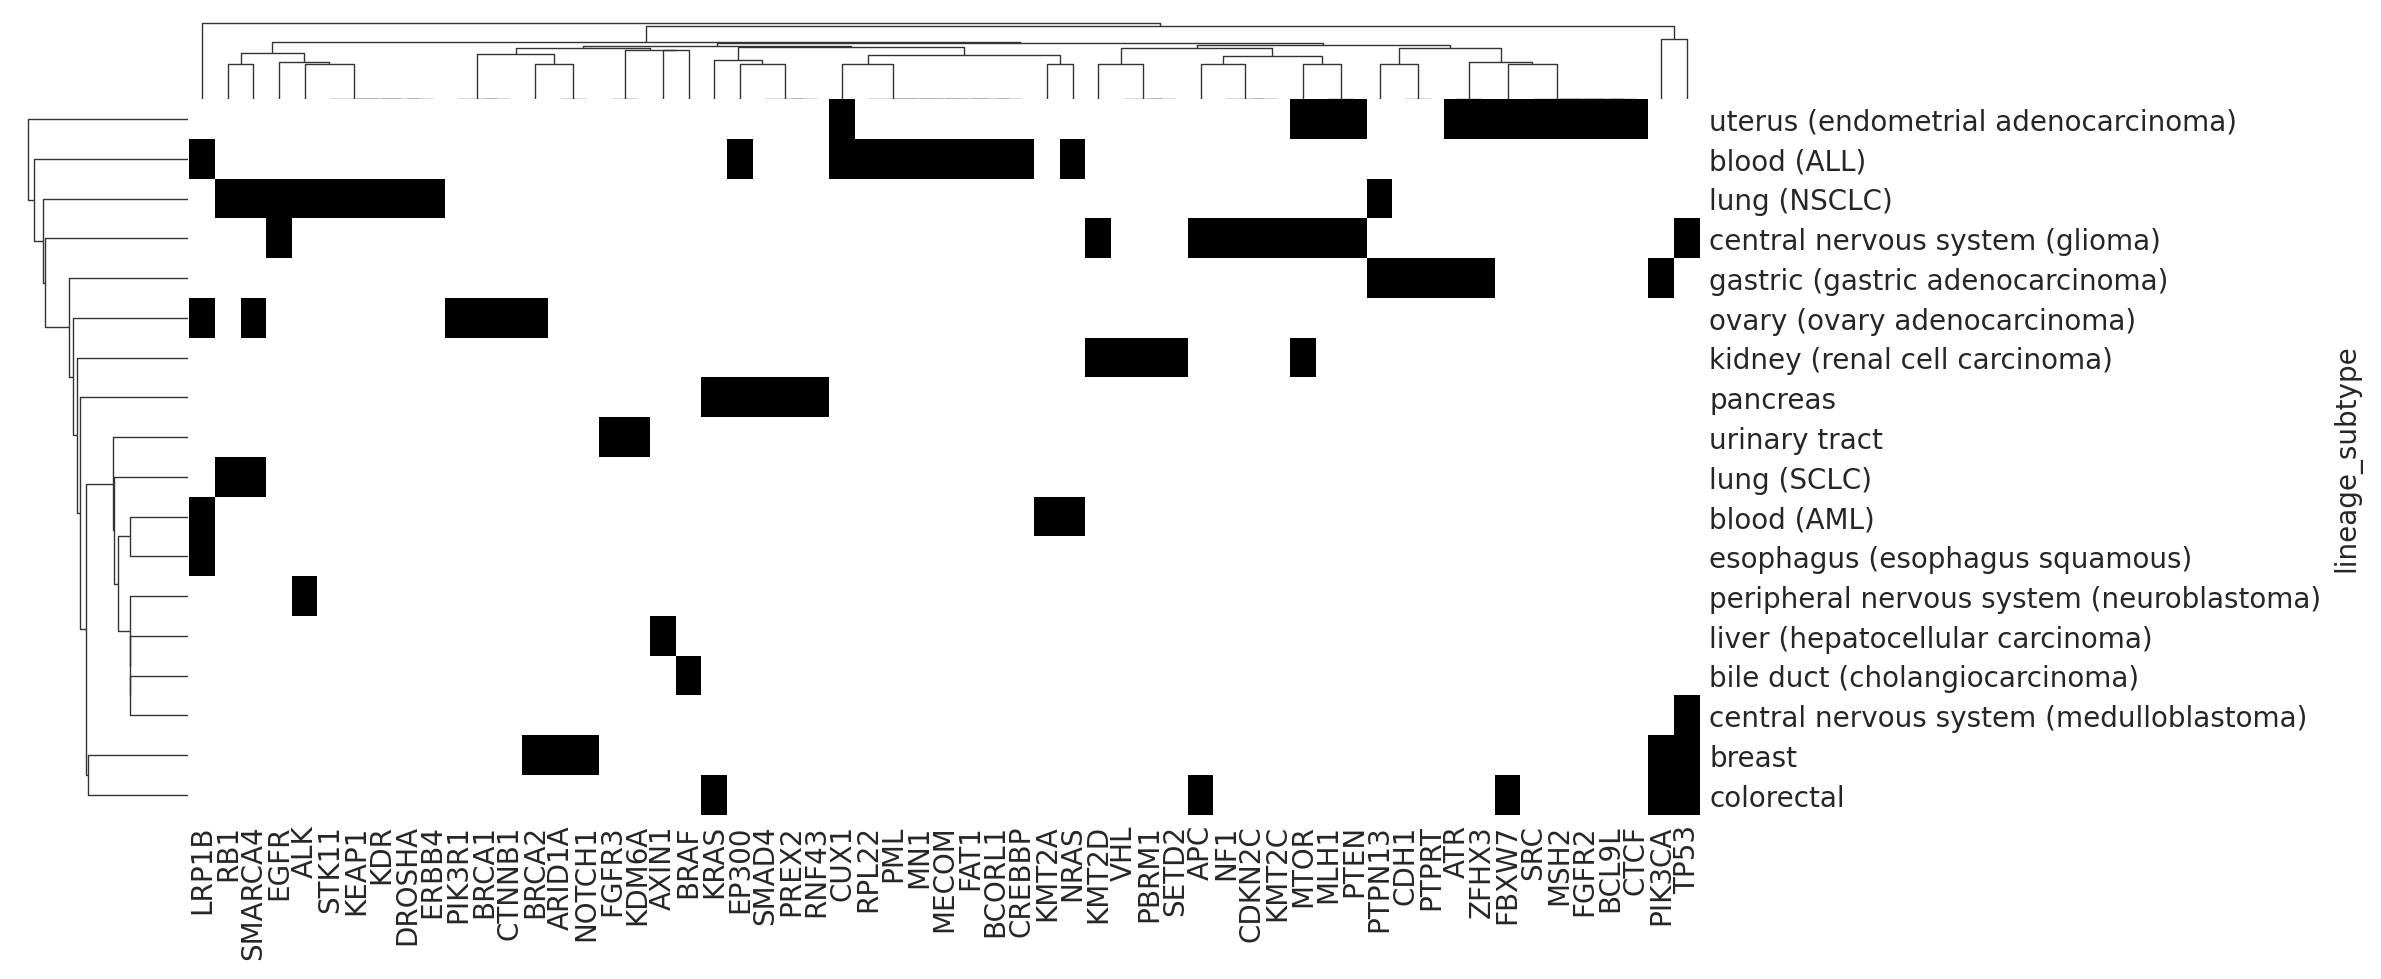

In [18]:
_cancer_gene_pairs: list[tuple[str, str]] = []
for cg, targets in cancer_genes.items():
    for target in targets:
        _cancer_gene_pairs.append((cg, target))

cancer_genes_df = pd.DataFrame(
    _cancer_gene_pairs, columns=("lineage_subtype", "cancer_gene")
)
cancer_genes_df.head(3)

cancer_genes_X = (
    cancer_genes_df.assign(x=1)
    .pivot_wider("lineage_subtype", names_from="cancer_gene", values_from="x")
    .fillna(0)
    .set_index("lineage_subtype")
)
cancer_genes_X.to_csv(OUTPUT_DIR / "cancer-genes-per-lineage.csv", index=True)
sns.clustermap(
    cancer_genes_X,
    cmap="Greys",
    vmin=0,
    vmax=1,
    cbar_pos=None,
    figsize=(12, 5),
    xticklabels=1,
    yticklabels=1,
    dendrogram_ratio=(0.1, 0.1),
)

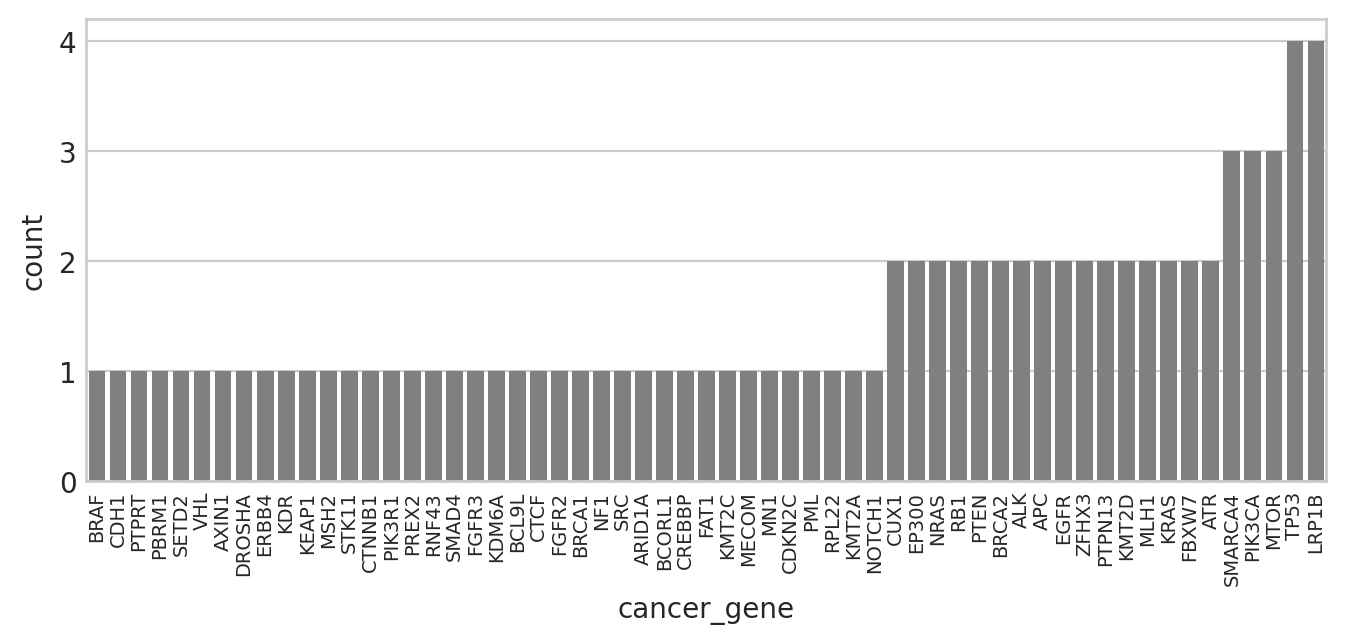

In [19]:
all_cancer_genes = []
for v in cancer_genes.values():
    all_cancer_genes += v
cg_counts = Counter(all_cancer_genes)
cg_counts_df = pd.DataFrame(
    {"cancer_gene": list(cg_counts.keys()), "count": list(cg_counts.values())}
).sort_values("count")

_, ax = plt.subplots(figsize=(8, 3))
sns.barplot(data=cg_counts_df, x="cancer_gene", y="count", color="gray", ax=ax)
ax.tick_params("x", rotation=90, labelsize=7)

In [20]:
CANCER_GENE = "SMARCA4"
for lineage, cgs in cancer_genes.items():
    if CANCER_GENE in cgs:
        print(lineage)

lung (NSCLC)
lung (SCLC)
ovary (ovary adenocarcinoma)


In [21]:
multi_subtype_cgs = [st for st, ct in cg_counts.items() if ct > 1]
multi_subtype_cgs.sort()

In [22]:
filt_sublineage_pal = {
    k: v
    for k, v in sublineage_pal.items()
    if k in synlet_post["lineage_subtype"].toset()
}

Text(0, 0.5, 'density')

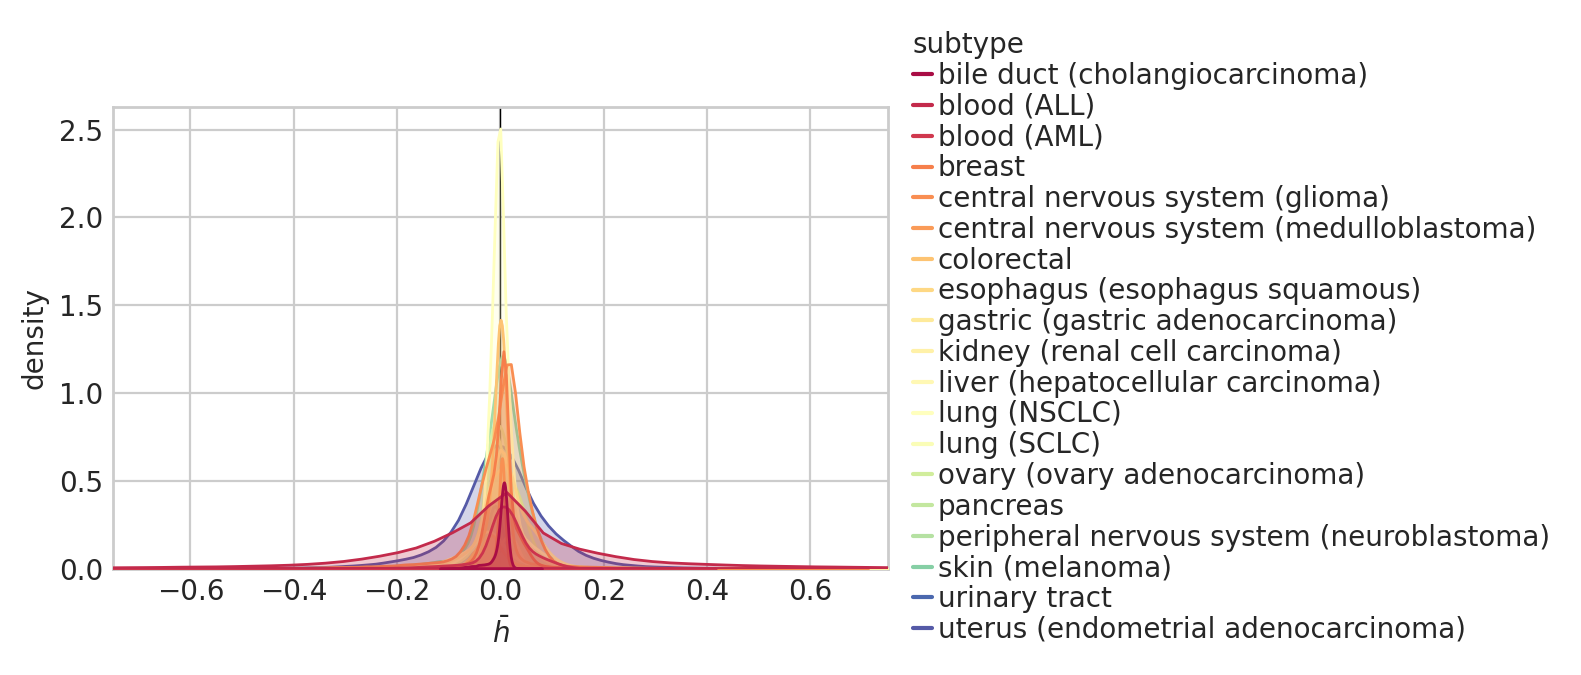

In [23]:
_, ax = plt.subplots(figsize=(5, 3))
ax.axvline(0, color="k", lw=0.5, zorder=1)
sns.kdeplot(
    data=synlet_post,
    x="mean_h",
    hue="lineage_subtype",
    palette=filt_sublineage_pal,
    lw=1,
    ax=ax,
    zorder=10,
    fill=True,
)
leg = ax.legend(
    handles=pal_to_legend_handles(filt_sublineage_pal),
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    labelspacing=0.1,
    handlelength=0.7,
    handletextpad=0.2,
    title="subtype",
)
align_legend_title(leg, "left")
ax.set_xlim(-0.75, 0.75)
ax.set_xlabel(r"$\bar{h}$")
ax.set_ylabel("density")

In [24]:
joint_synlet_pairs = []
for cg in multi_subtype_cgs:
    subtypes = list(
        synlet_post.query(f"cancer_gene == '{cg}'")["lineage_subtype"].unique()
    )
    subtypes.sort()
    for pair in combinations(subtypes, 2):
        joint_synlet_pairs.append((cg, pair))

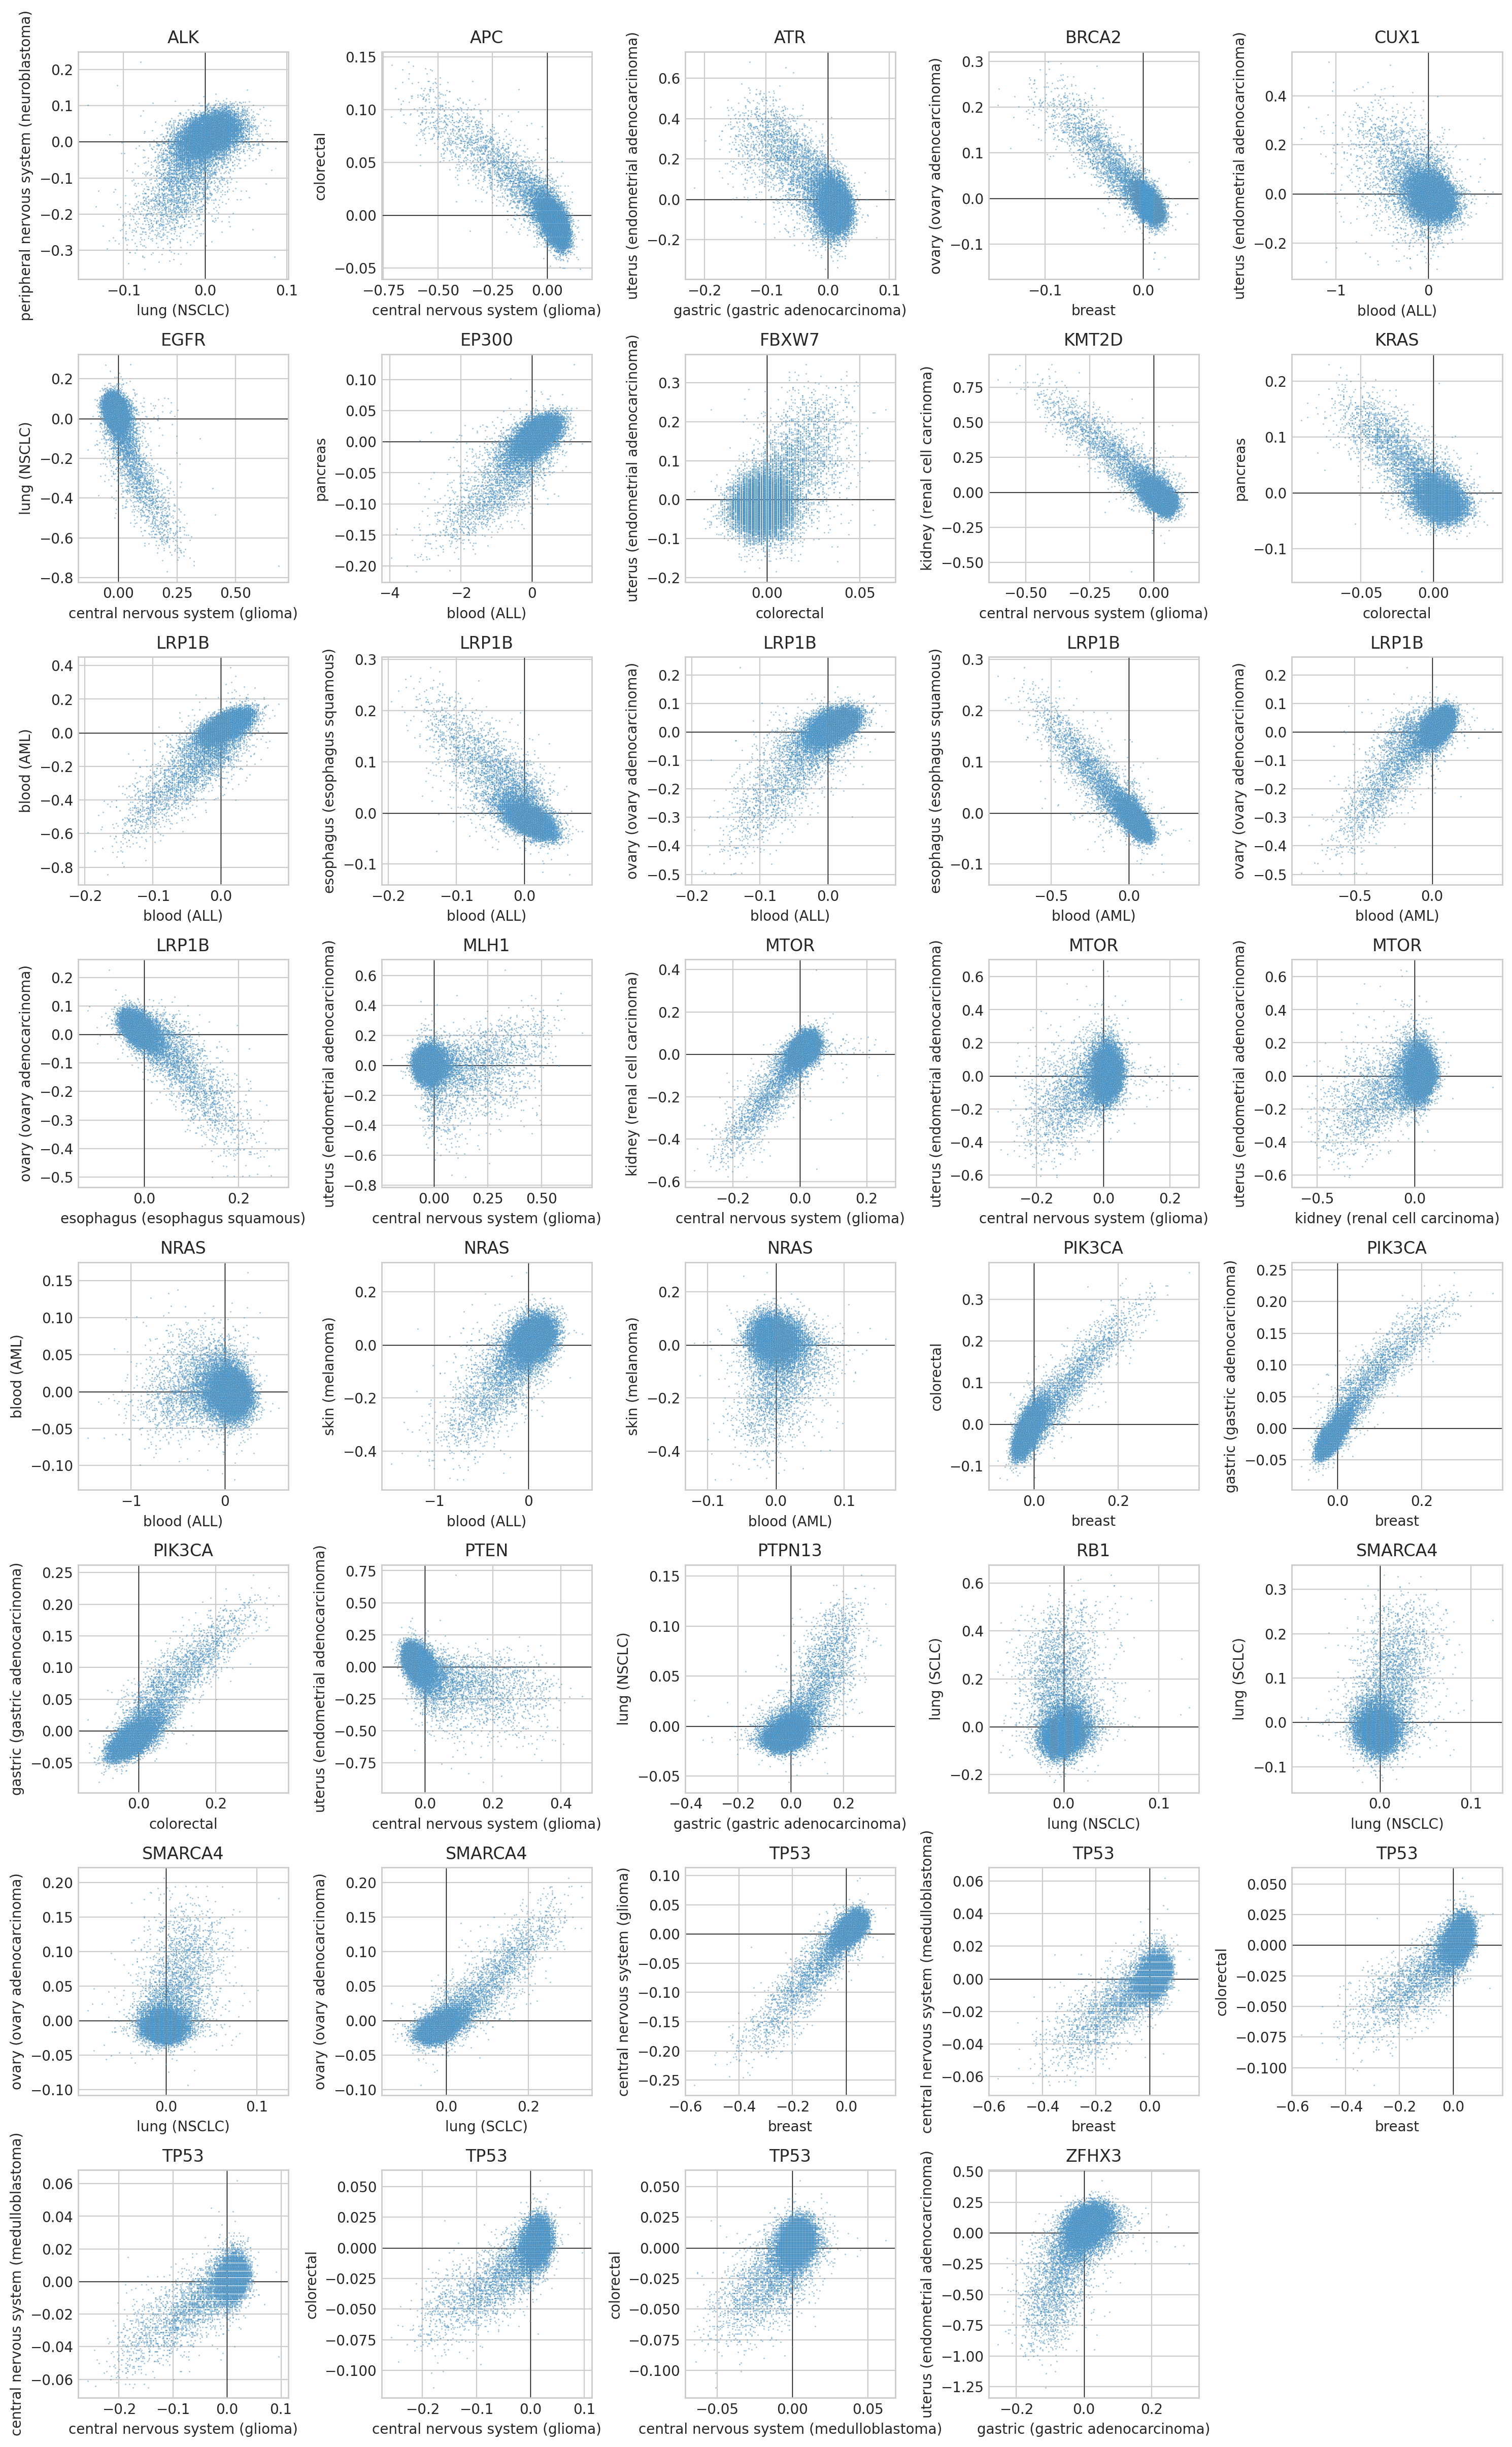

In [25]:
ncols = 5
nrows = ceil(len(joint_synlet_pairs) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows))

for ax, (cg, sts) in zip(axes.flatten(), joint_synlet_pairs):
    ax.set_title(cg)
    df = (
        synlet_post.query(f"cancer_gene == '{cg}'")
        .filter_column_isin("lineage_subtype", sts)
        .pivot_wider("hugo_symbol", names_from="lineage_subtype", values_from="mean_h")
    )
    assert df.shape[1] == 3
    ax.axvline(0, lw=0.5, color="k", zorder=1)
    ax.axhline(0, lw=0.5, color="k", zorder=1)
    sns.scatterplot(
        data=df, x=df.columns[1], y=df.columns[2], s=1, alpha=0.5, ax=ax, zorder=10
    )

for ax in axes.flatten()[len(joint_synlet_pairs) :]:
    ax.axis("off")

fig.tight_layout()
plt.show()

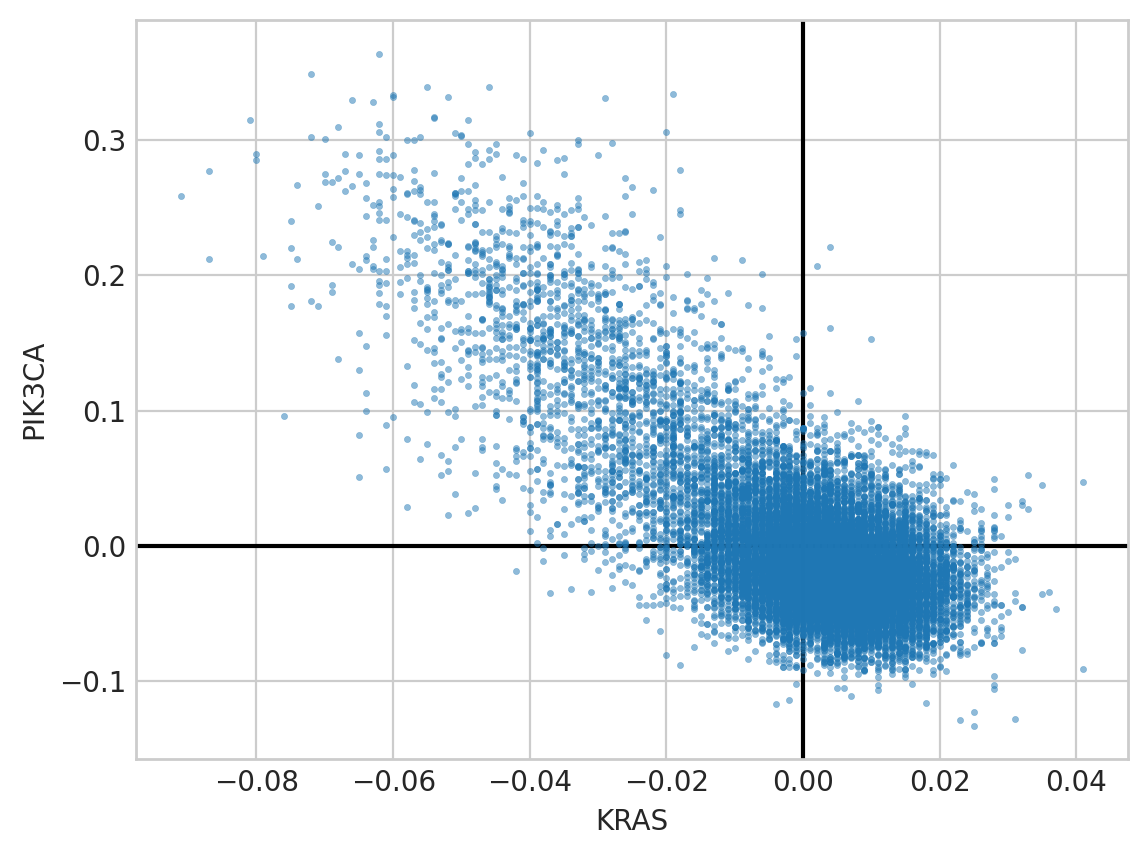

In [26]:
kras_pik3ca_crc = (
    synlet_post.query("lineage_subtype == 'colorectal'")
    .filter_column_isin("cancer_gene", ["KRAS", "PIK3CA"])
    .pivot_wider("hugo_symbol", names_from="cancer_gene", values_from="mean_h")
)
ax = sns.scatterplot(
    data=kras_pik3ca_crc, x="KRAS", y="PIK3CA", s=5, alpha=0.5, edgecolor=None, zorder=2
)
ax.axhline(0, c="k", zorder=1)
ax.axvline(0, c="k", zorder=1)

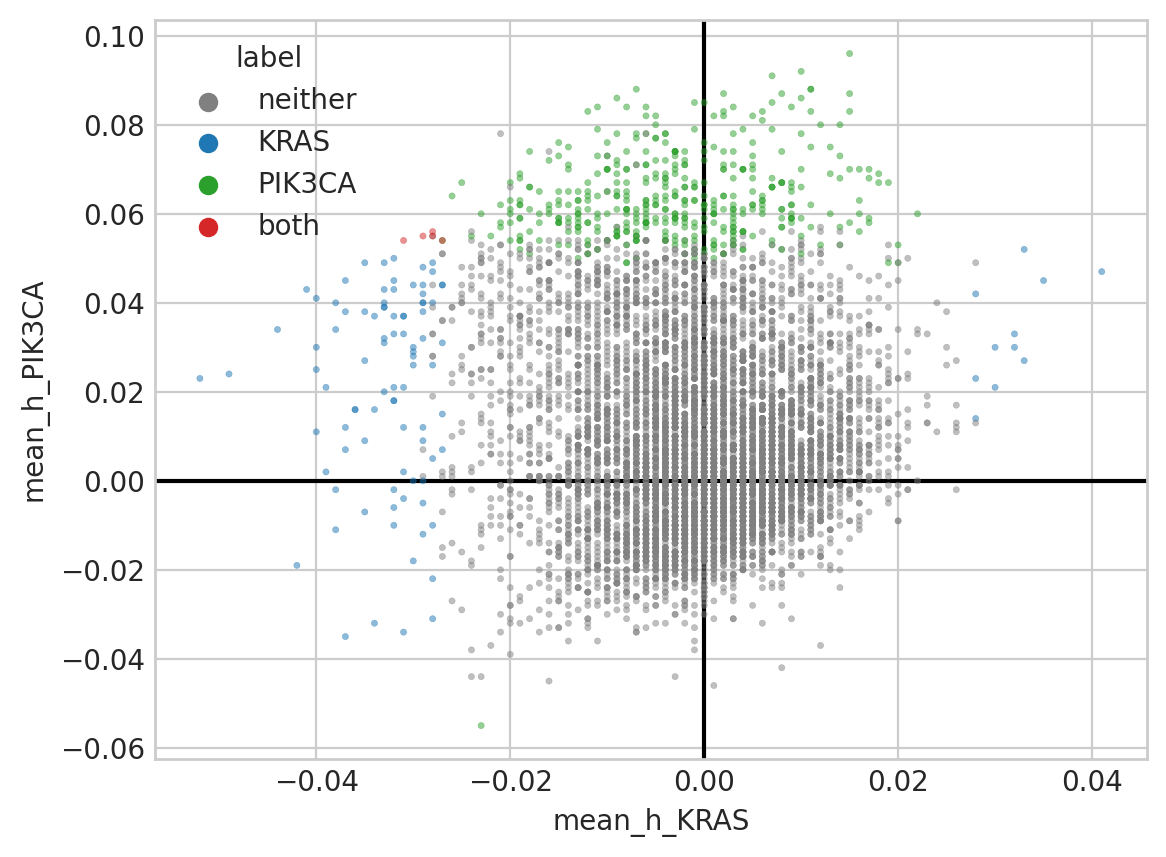

In [27]:
def _assign_labels_for_kras_pik3ca_hdi_zero(df: pd.DataFrame) -> pd.DataFrame:
    lbl = []
    for _, x in df.iterrows():
        kras, pik3ca = not x["hdi_zero_h_KRAS"], not x["hdi_zero_h_PIK3CA"]
        if kras and pik3ca:
            lbl.append("both")
        elif kras:
            lbl.append("KRAS")
        elif pik3ca:
            lbl.append("PIK3CA")
        else:
            lbl.append("neither")
    df["label"] = lbl
    return df


kras_pik3ca_crc = (
    synlet_post.query("lineage_subtype == 'colorectal'")
    .filter_column_isin("cancer_gene", ["KRAS", "PIK3CA"])
    .query("hdi_zero_mu_a")
    .pivot_wider(
        "hugo_symbol", names_from="cancer_gene", values_from=["mean_h", "hdi_zero_h"]
    )
    .pipe(_assign_labels_for_kras_pik3ca_hdi_zero)
)

pal = {"neither": "grey", "KRAS": "tab:blue", "PIK3CA": "tab:green", "both": "tab:red"}

ax = sns.scatterplot(
    data=kras_pik3ca_crc,
    x="mean_h_KRAS",
    y="mean_h_PIK3CA",
    hue="label",
    palette=pal,
    s=5,
    alpha=0.5,
    edgecolor=None,
    zorder=2,
)
ax.axhline(0, c="k", zorder=1)
ax.axvline(0, c="k", zorder=1)

In [28]:
GENE = "DONSON"
crc_h_test = (
    postmen["colorectal"]
    .trace.posterior.get("h")
    .sel(gene=GENE, cancer_gene=["KRAS", "PIK3CA"])
)

There is a correlation between genes, not the posterior draws, though

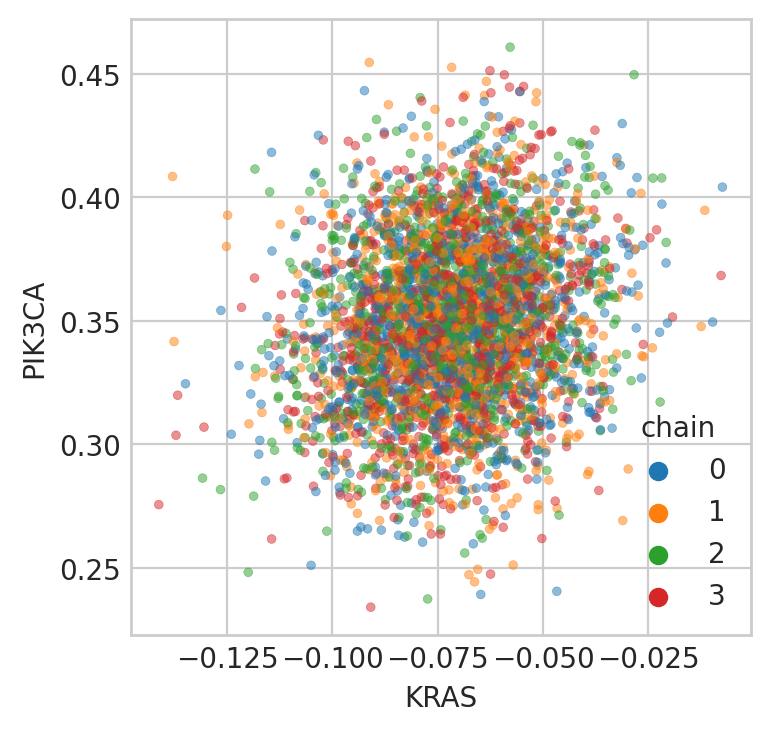

In [29]:
crc_h_test_df = (
    crc_h_test.to_dataframe()
    .reset_index()
    .pivot_wider(["chain", "draw"], names_from="cancer_gene", values_from="h")
    .astype({"chain": "category"})
    .sample(frac=1)
)
_, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(
    data=crc_h_test_df,
    x="KRAS",
    y="PIK3CA",
    hue="chain",
    alpha=0.5,
    s=10,
    edgecolor=None,
    zorder=10,
    ax=ax,
)
plt.show()

In [30]:
def get_gene_effect_corr_summary_from_trace(
    pm: PostDataMan, stash: bool = True
) -> pd.DataFrame:
    stash_fp = STASH_DIR / f"post-gene-effect-corr-from-trace-df_{pm.id}-post.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)

    _gene_var_names = ["mu_a", "b", "d", "f"]
    try:
        cgs = pm.trace.posterior.coords.get("cancer_gene")
    except AssertionError:
        print(f"Skipping {pm.id}")
        return pd.DataFrame()

    if cgs is not None:
        _gene_var_names += [f"h_{g}" for g in cgs]

    post = (
        az.summary(pm.trace, var_names=["genes_chol_cov_corr"], kind="stats")
        .pipe(extract_coords_param_names, names=["idx1", "idx2"])
        .astype({"idx1": int, "idx2": int})
        .assign(
            var1=lambda d: [_gene_var_names[i] for i in d["idx1"]],
            var2=lambda d: [_gene_var_names[i] for i in d["idx2"]],
        )
        .drop(columns=["idx1", "idx2"])
        .reset_index(drop=True)
        .assign(lineage_subtype=pm.id)
    )

    post.to_csv(stash_fp, index=False)
    return post

In [31]:
gene_effect_corrs = (
    pd.concat(
        [
            get_gene_effect_corr_summary_from_trace(pm, stash=True)
            for pm in postmen.posteriors
        ]
    )
    .reset_index(drop=True)
    .assign(
        hdi_zero=lambda d: zero_in_hdi(d["hdi_5.5%"], d["hdi_94.5%"]),
        lineage=lambda d: d["lineage_subtype"].map(sub_to_lineage),
    )
)
gene_effect_corrs.to_csv(
    OUTPUT_DIR / "gene-effect-covariance-posteriors.csv", index=False
)
gene_effect_corrs.head(5)

mean     sd  hdi_5.5%  hdi_94.5%  var1    var2  \
0  1.000  0.000     1.000      1.000  mu_a    mu_a   
1  0.283  0.012     0.263      0.301  mu_a       b   
2 -0.652  0.011    -0.670     -0.634  mu_a       d   
3 -0.112  0.035    -0.166     -0.054  mu_a       f   
4  0.943  0.022     0.910      0.978  mu_a  h_BRAF   

                  lineage_subtype  hdi_zero    lineage  
0  bile duct (cholangiocarcinoma)     False  bile duct  
1  bile duct (cholangiocarcinoma)     False  bile duct  
2  bile duct (cholangiocarcinoma)     False  bile duct  
3  bile duct (cholangiocarcinoma)     False  bile duct  
4  bile duct (cholangiocarcinoma)     False  bile duct

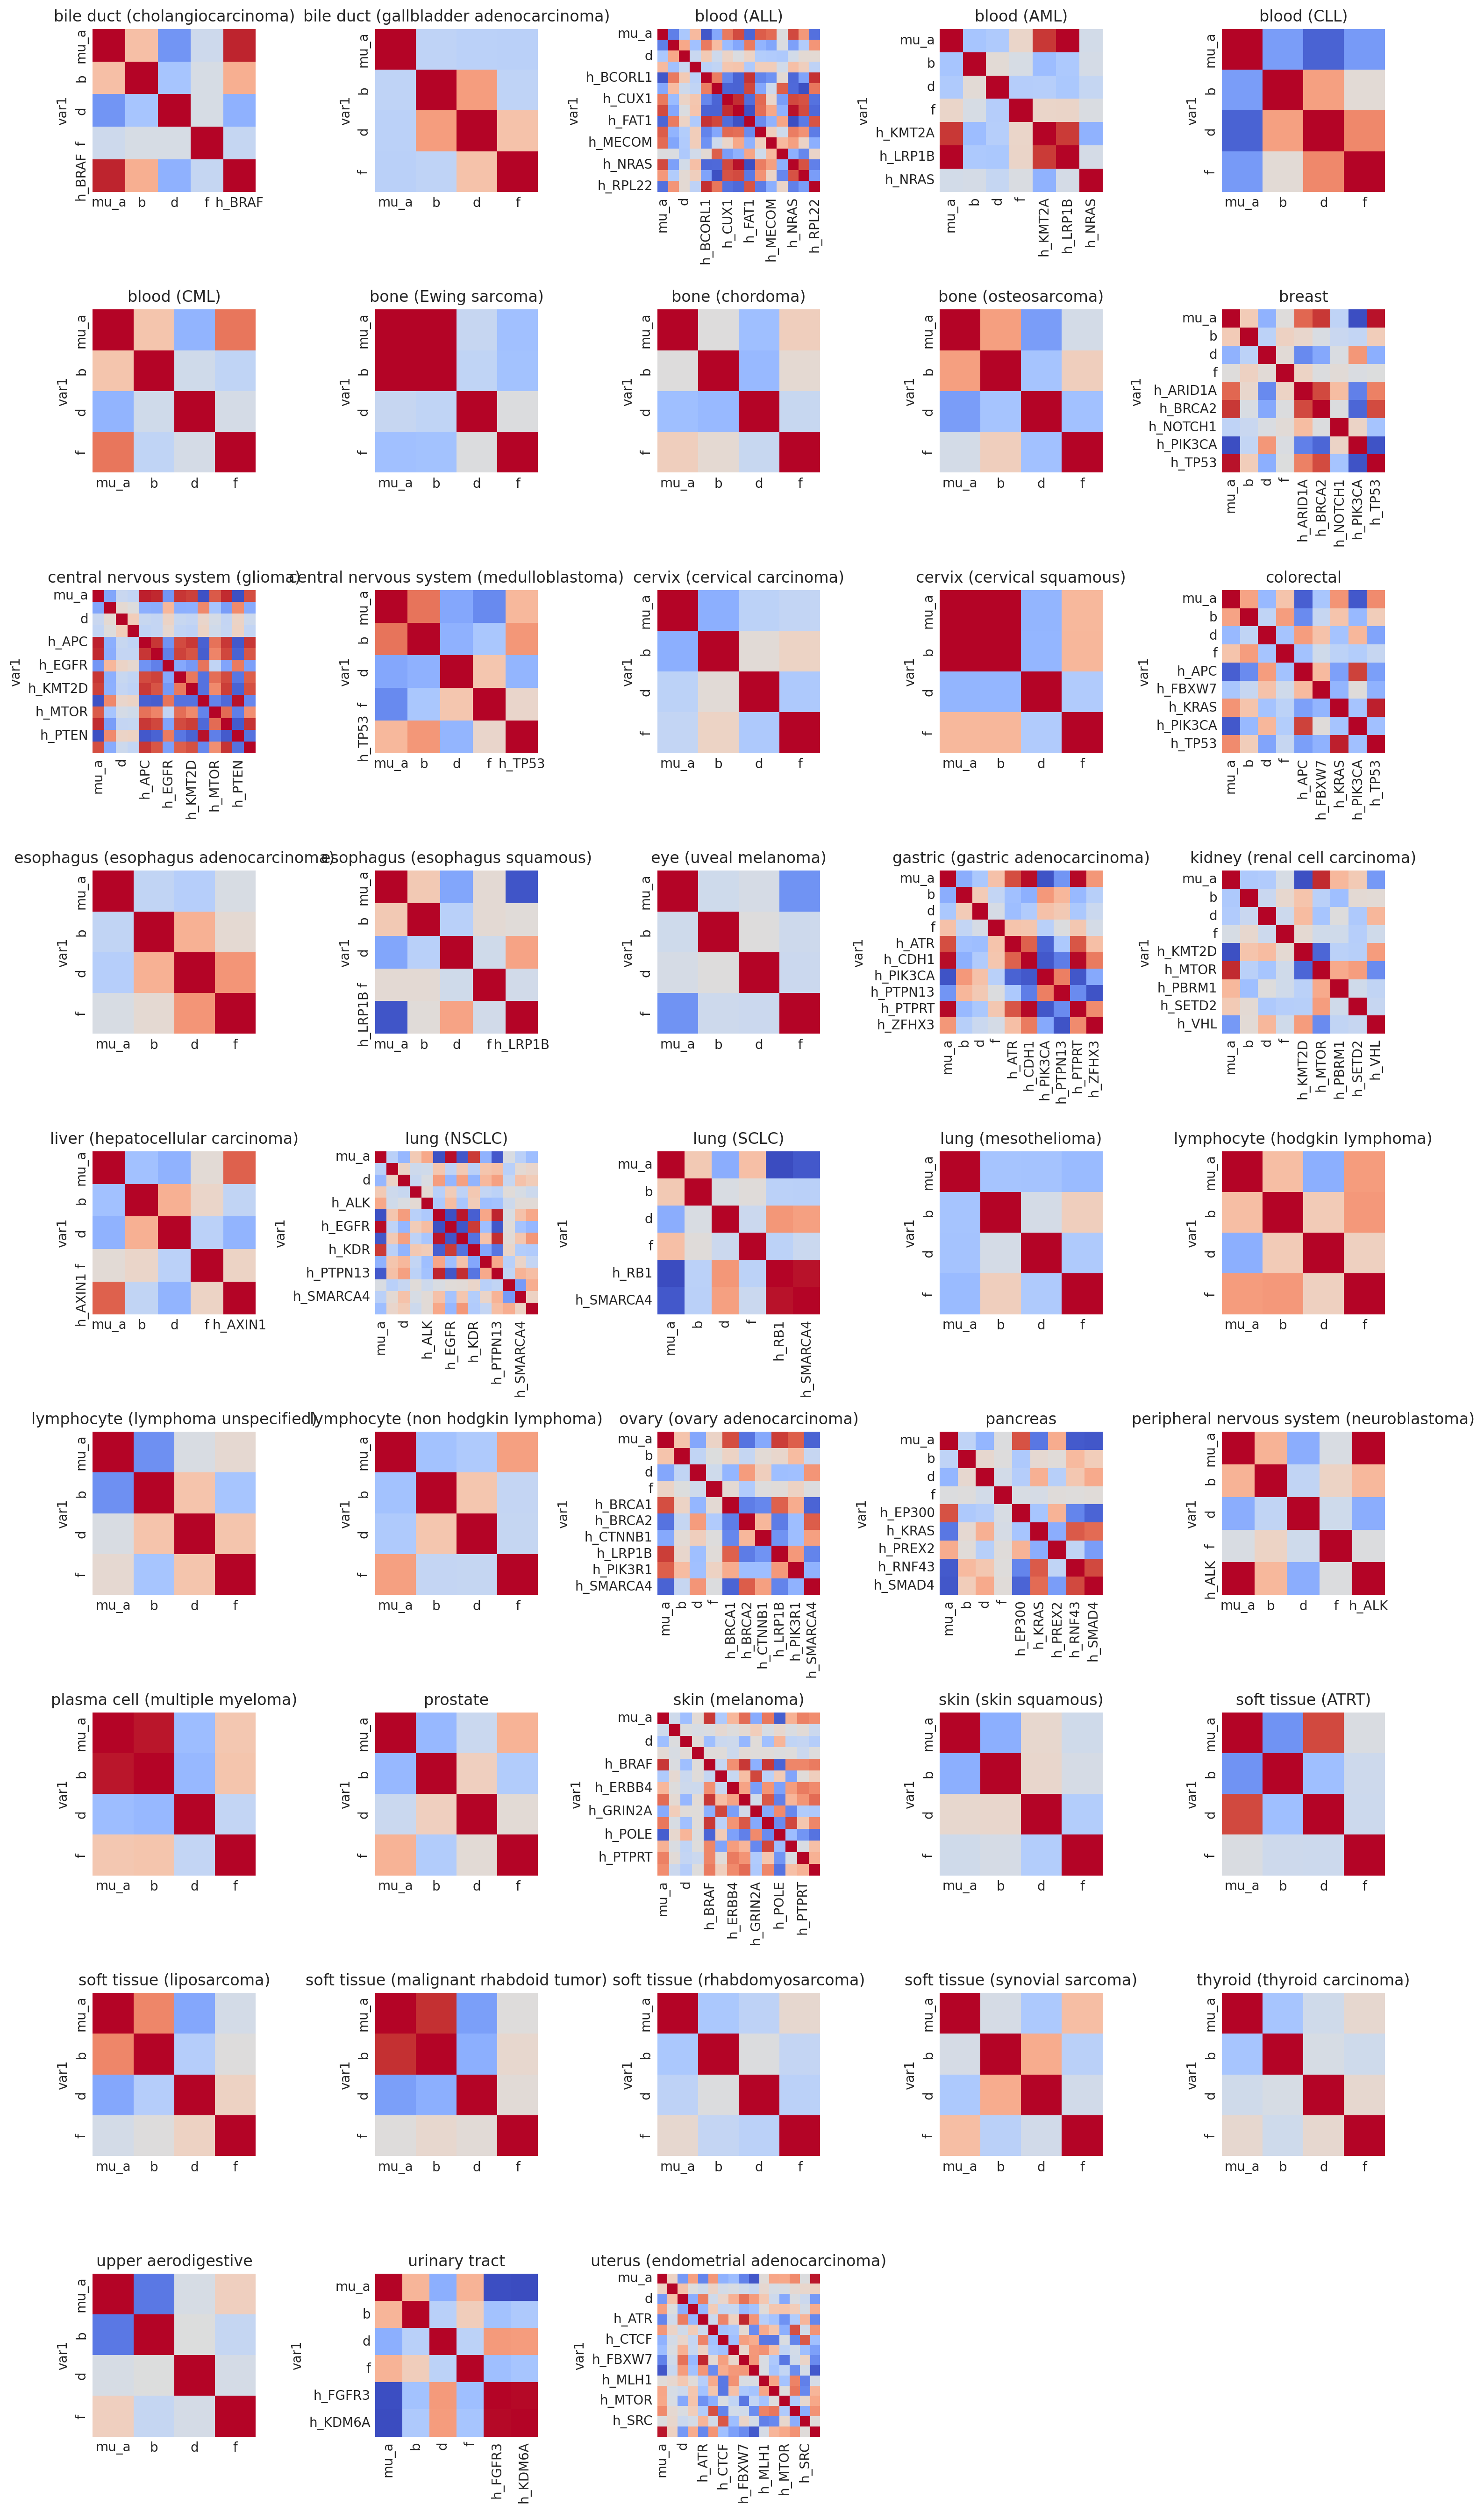

In [32]:
n_axes = gene_effect_corrs["lineage_subtype"].nunique()
ncols = 5
nrows = ceil(n_axes / ncols)
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows), sharex=False, sharey=False
)

for ax, (st, df) in zip(axes.flatten(), gene_effect_corrs.groupby("lineage_subtype")):
    ax.set_title(st)
    order = list(df["var1"].unique())
    for c in ["var1", "var2"]:
        df[c] = pd.Categorical(df[c], categories=order, ordered=True)
    X = df.pivot_wider("var1", names_from="var2", values_from="mean").set_index("var1")
    sns.heatmap(
        X, cmap="coolwarm", vmin=-1, vmax=1, center=0, square=True, ax=ax, cbar=False
    )
    if (leg := ax.get_legend()) is not None:
        leg.remove()

for ax in axes.flatten()[n_axes:]:
    ax.axis("off")

fig.tight_layout()
plt.show()

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


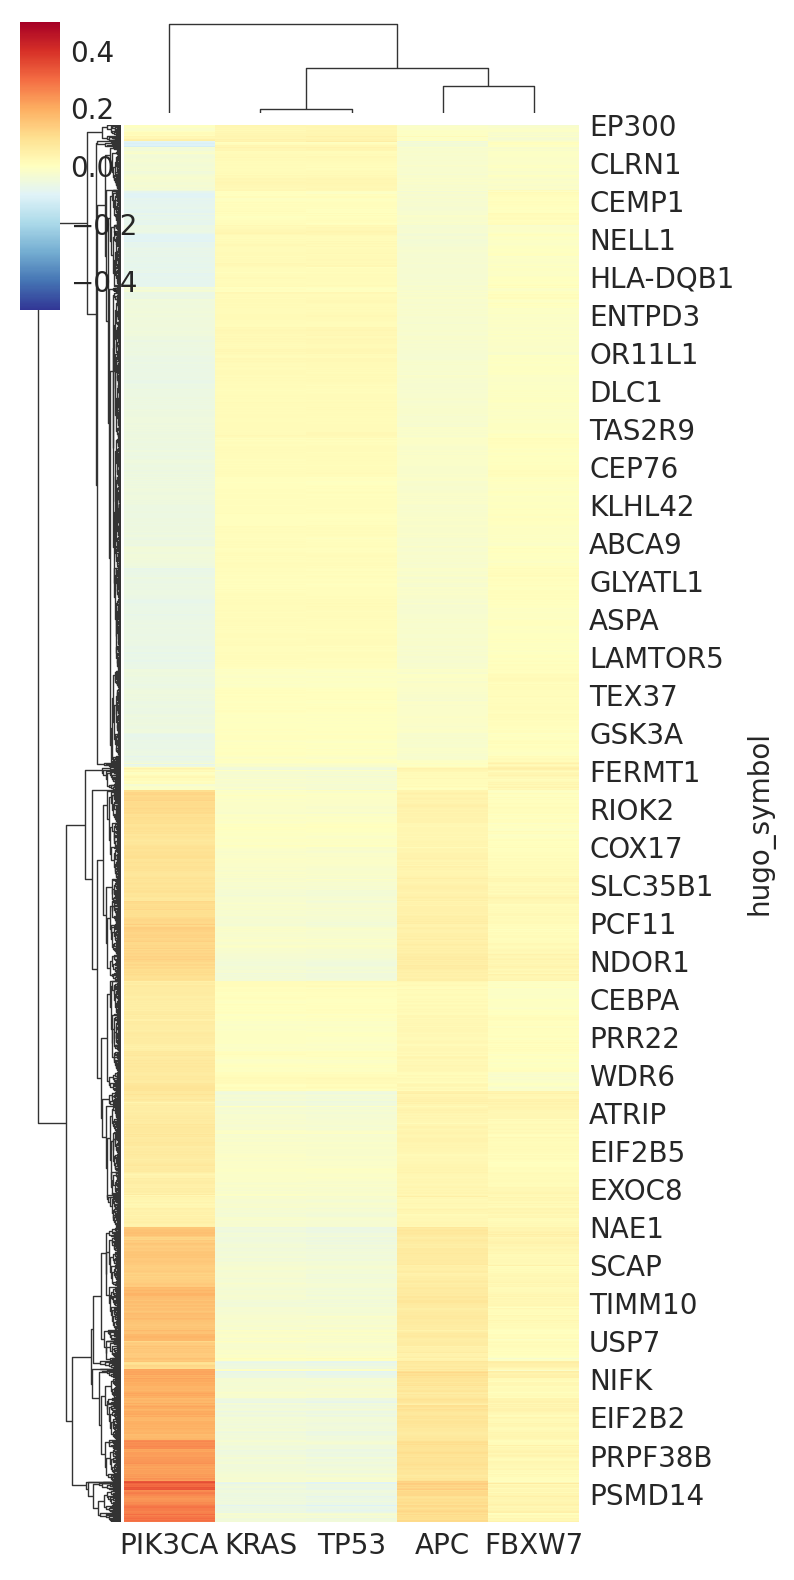

In [33]:
crc_synlet = synlet_post.query("lineage_subtype == 'colorectal'").reset_index(drop=True)
nonzero_hdi_crc = crc_synlet.query("not hdi_zero_h")["hugo_symbol"].toset()
crc_synlet_X = (
    crc_synlet.filter_column_isin("hugo_symbol", nonzero_hdi_crc)
    .pivot_wider("hugo_symbol", names_from="cancer_gene", values_from="mean_h")
    .set_index("hugo_symbol")
)
sns.clustermap(
    crc_synlet_X,
    cmap="RdYlBu_r",
    center=0,
    vmin=-0.5,
    vmax=0.5,
    figsize=(4, 8),
    dendrogram_ratio=(0.1 * 8 / 5, 0.1 * 5 / 8),
)
plt.show()

number of genes: 686


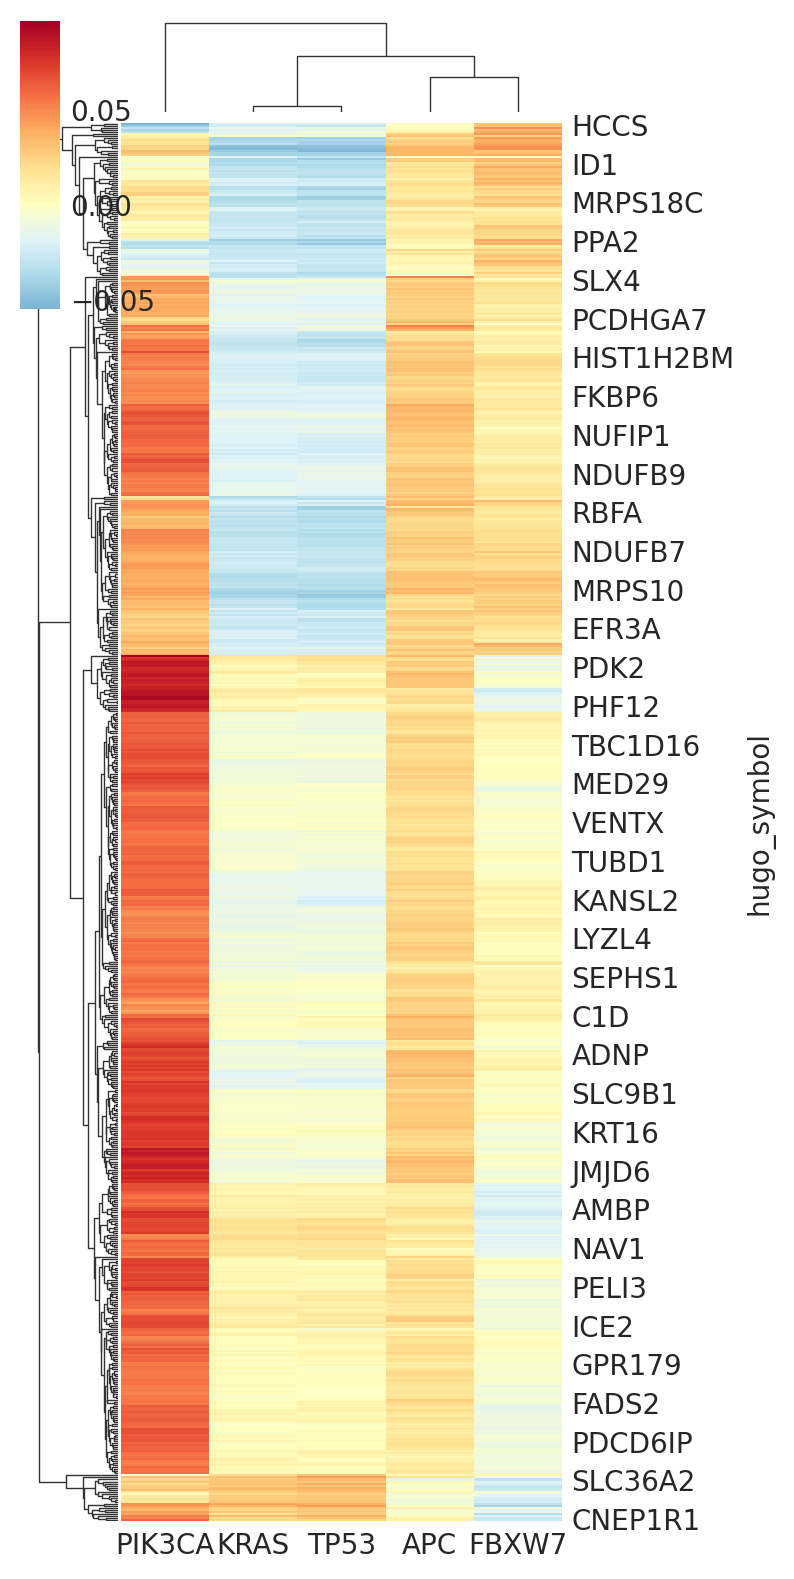

In [34]:
crc_synlet = synlet_post.query("lineage_subtype == 'colorectal'").reset_index(drop=True)
sl_hits = crc_synlet.query("not hdi_zero_h and hdi_zero_mu_a")["hugo_symbol"].toset()
print(f"number of genes: {len(sl_hits)}")
crc_synlet_X = (
    crc_synlet.filter_column_isin("hugo_symbol", sl_hits)
    .pivot_wider("hugo_symbol", names_from="cancer_gene", values_from="mean_h")
    .set_index("hugo_symbol")
)
sns.clustermap(
    crc_synlet_X,
    cmap="RdYlBu_r",
    center=0,
    figsize=(4, 8),
    dendrogram_ratio=(0.1 * 8 / 5, 0.1 * 5 / 8),
)
plt.show()

In [35]:
def get_data_for_genes(
    pm: PostDataMan, genes: Collection[str], stash: bool = True
) -> pd.DataFrame:
    _genes = sorted(list(set(genes)))
    _genes_hash = str_hash("__".join(_genes))
    stash_fp = STASH_DIR / f"original-data_{pm.id}-{_genes_hash}.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)

    df = (
        dd.read_csv(pm.data_file, low_memory=False, dtype={"age": "float64"})
        .query("hugo_symbol in @genes", local_dict={"genes": genes})
        .compute()
        .reset_index(drop=True)
    )
    df.to_csv(stash_fp, index=False)
    return df


def get_mutation_data_for_genes(
    pm: PostDataMan, genes: Collection[str], stash: bool = True
) -> pd.DataFrame:
    _genes = sorted(list(set(genes)))
    _genes_hash = str_hash("__".join(_genes))
    stash_fp = STASH_DIR / f"mutation-data_{pm.id}-{_genes_hash}.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)

    df = (
        dd.read_csv(
            pm.data_file,
            low_memory=False,
            usecols=["hugo_symbol", "depmap_id", "is_mutated"],
        )
        .query("hugo_symbol in @genes", local_dict={"genes": genes})
        .drop_duplicates()
        .compute()
        .reset_index(drop=True)
    )
    df.to_csv(stash_fp, index=False)
    return df

<AxesSubplot:xlabel='pik3ca_mut', ylabel='lfc'>

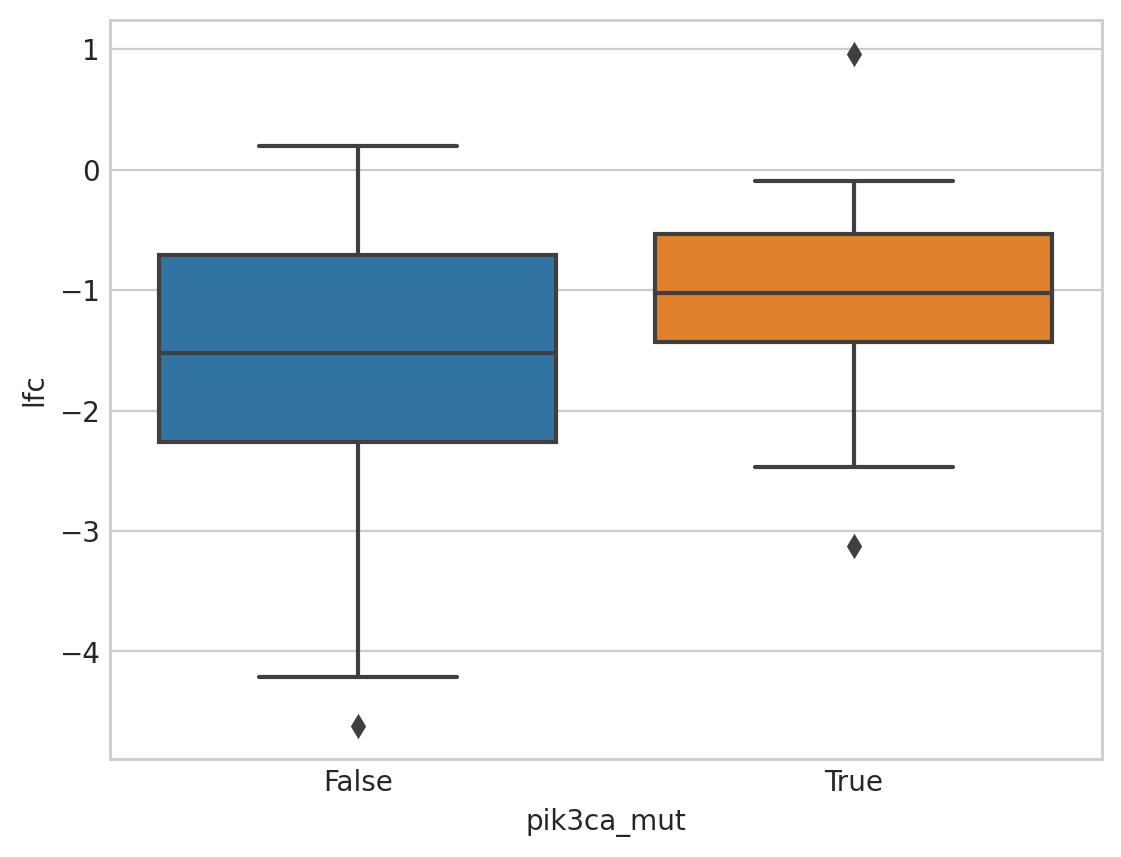

In [36]:
cancer_gene_mut = (
    get_mutation_data_for_genes(postmen["colorectal"], "PIK3CA")
    .rename(columns={"is_mutated": "pik3ca_mut"})
    .drop(columns=["hugo_symbol"])
)
target_df = get_data_for_genes(postmen["colorectal"], "PSMD14").merge(
    cancer_gene_mut, on="depmap_id"
)
sns.boxplot(data=target_df, x="pik3ca_mut", y="lfc")

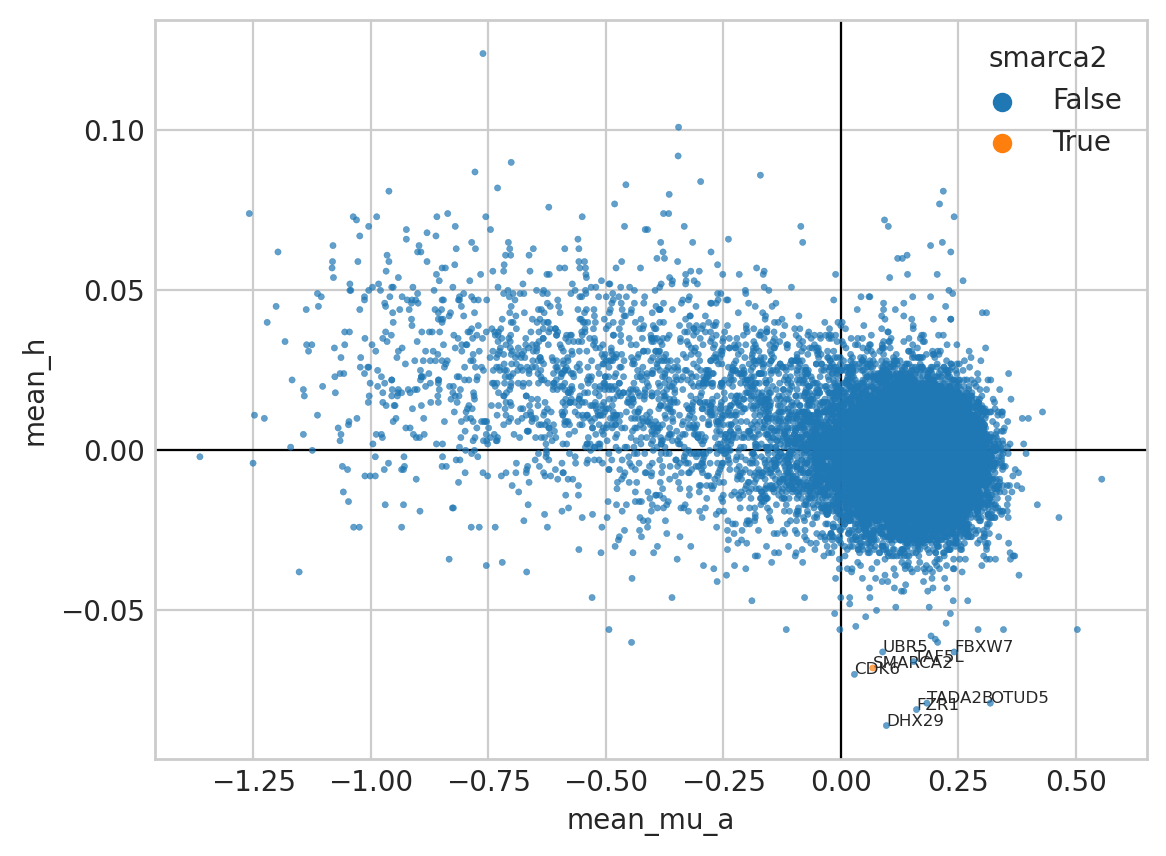

In [37]:
df = (
    synlet_post.query("lineage_subtype == 'lung (NSCLC)' and cancer_gene == 'SMARCA4'")
    .assign(smarca2=lambda d: d["hugo_symbol"] == "SMARCA2")
    .sort_values("smarca2")
)
ax = sns.scatterplot(
    data=df,
    x="mean_mu_a",
    y="mean_h",
    hue="smarca2",
    zorder=10,
    alpha=0.7,
    s=5,
    edgecolor=None,
)
ax.axvline(0, lw=0.8, c="k", zorder=1)
ax.axhline(0, lw=0.8, c="k", zorder=1)

hits = df.query("mean_mu_a > -0.25 and mean_h < -0.06")["hugo_symbol"].toset()
for hit in hits:
    d = df.query(f"hugo_symbol == '{hit}'")
    ax.text(d["mean_mu_a"].values[0], d["mean_h"].values[0], hit, size=6)

plt.show()

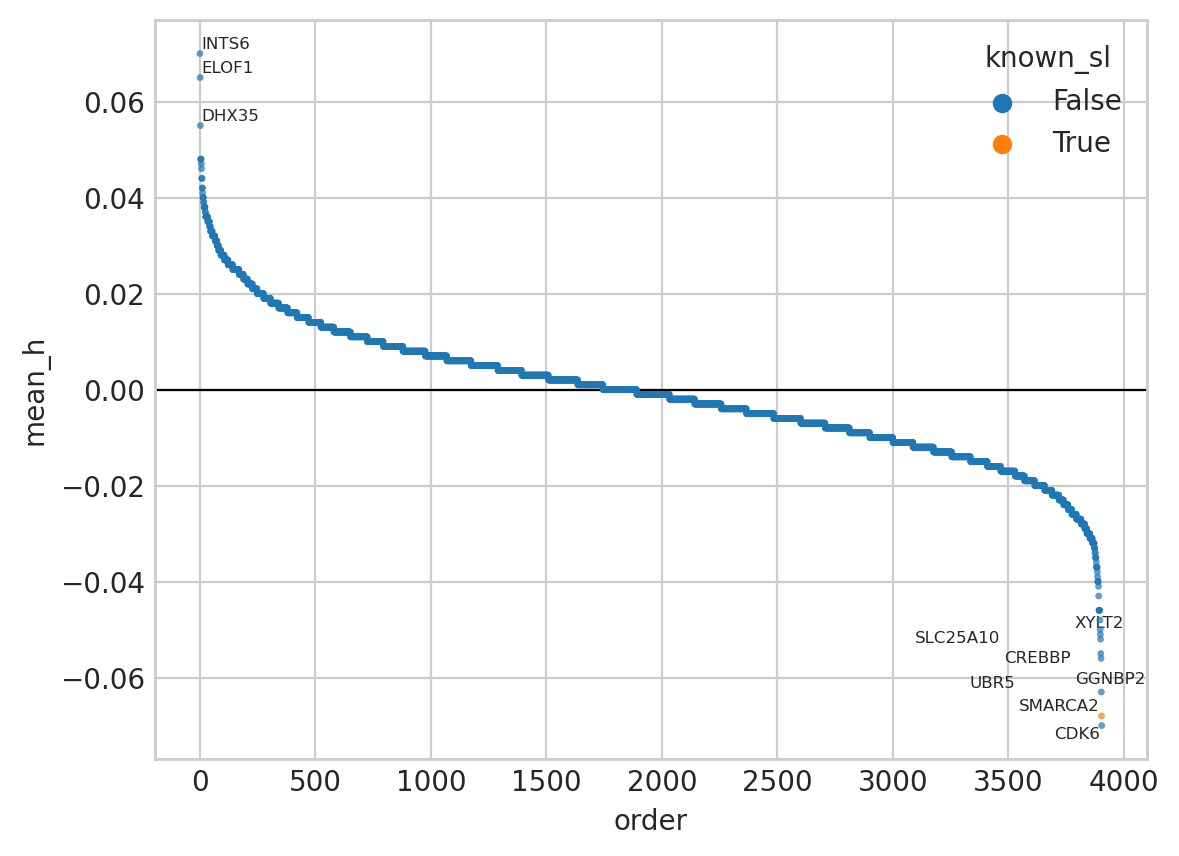

In [38]:
LINEAGE = "lung (NSCLC)"
CANCER_GENE = "SMARCA4"
SL_GENE = "SMARCA2"
df = (
    synlet_post.query(
        f"lineage_subtype == '{LINEAGE}' and cancer_gene == '{CANCER_GENE}'"
    )
    .assign(known_sl=lambda d: d["hugo_symbol"] == SL_GENE)
    .query("hdi_zero_mu_a")
    .sort_values("mean_h", ascending=False)
    .assign(order=lambda d: np.arange(len(d)))
    .sort_values("known_sl")
)

ax = sns.scatterplot(
    data=df,
    x="order",
    y="mean_h",
    hue="known_sl",
    zorder=10,
    alpha=0.7,
    s=5,
    edgecolor=None,
)
ax.axhline(0, lw=0.8, c="k", zorder=1)

hits = df.query("mean_h < -0.05")["hugo_symbol"].tolist()
hits += df.query("mean_h > 0.05")["hugo_symbol"].tolist()
texts = []
for hit in hits:
    d = df.query(f"hugo_symbol == '{hit}'")
    txt = ax.text(d["order"].values[0], d["mean_h"].values[0], hit, size=6)
    texts.append(txt)

adjust_text(texts, ax=ax)

plt.show()

In [39]:
cg_mut_data = get_mutation_data_for_genes(postmen[LINEAGE], genes=[CANCER_GENE])[
    ["depmap_id", "is_mutated"]
].rename(columns={"is_mutated": "cg_mut"})
sl_hits_data = get_data_for_genes(postmen[LINEAGE], genes=hits).merge(
    cg_mut_data, on="depmap_id"
)
sl_hits_data.to_csv(OUTPUT_DIR / "lung-nsclc-smarca4-data.csv", index=False)

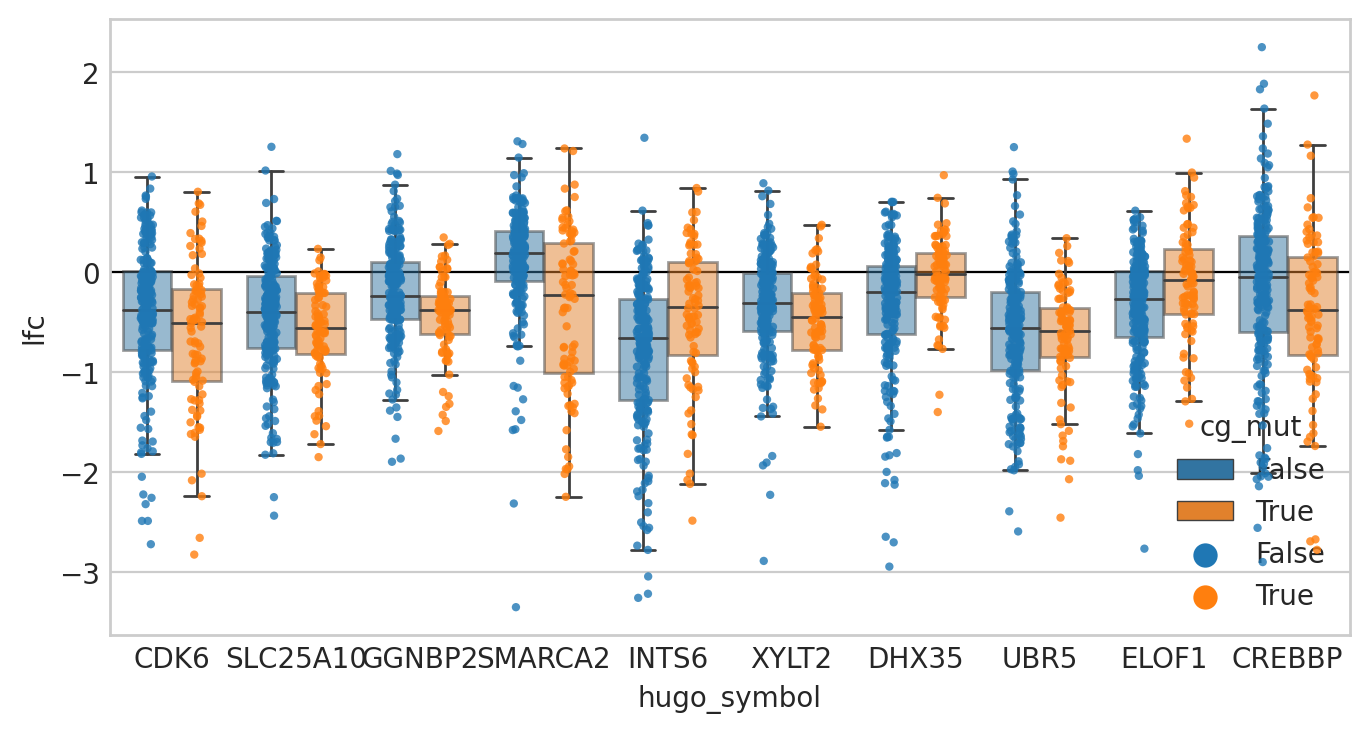

In [40]:
_, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(
    data=sl_hits_data,
    x="hugo_symbol",
    y="lfc",
    hue="cg_mut",
    ax=ax,
    dodge=True,
    showfliers=False,
    linewidth=1,
    boxprops={"alpha": 0.5, "zorder": 10},
    zorder=10,
)
sns.stripplot(
    data=sl_hits_data,
    x="hugo_symbol",
    y="lfc",
    hue="cg_mut",
    ax=ax,
    dodge=True,
    edgecolor=None,
    s=3,
    alpha=0.8,
    zorder=20,
)
ax.axhline(0, lw=0.8, c="k", zorder=1)
plt.show()

19


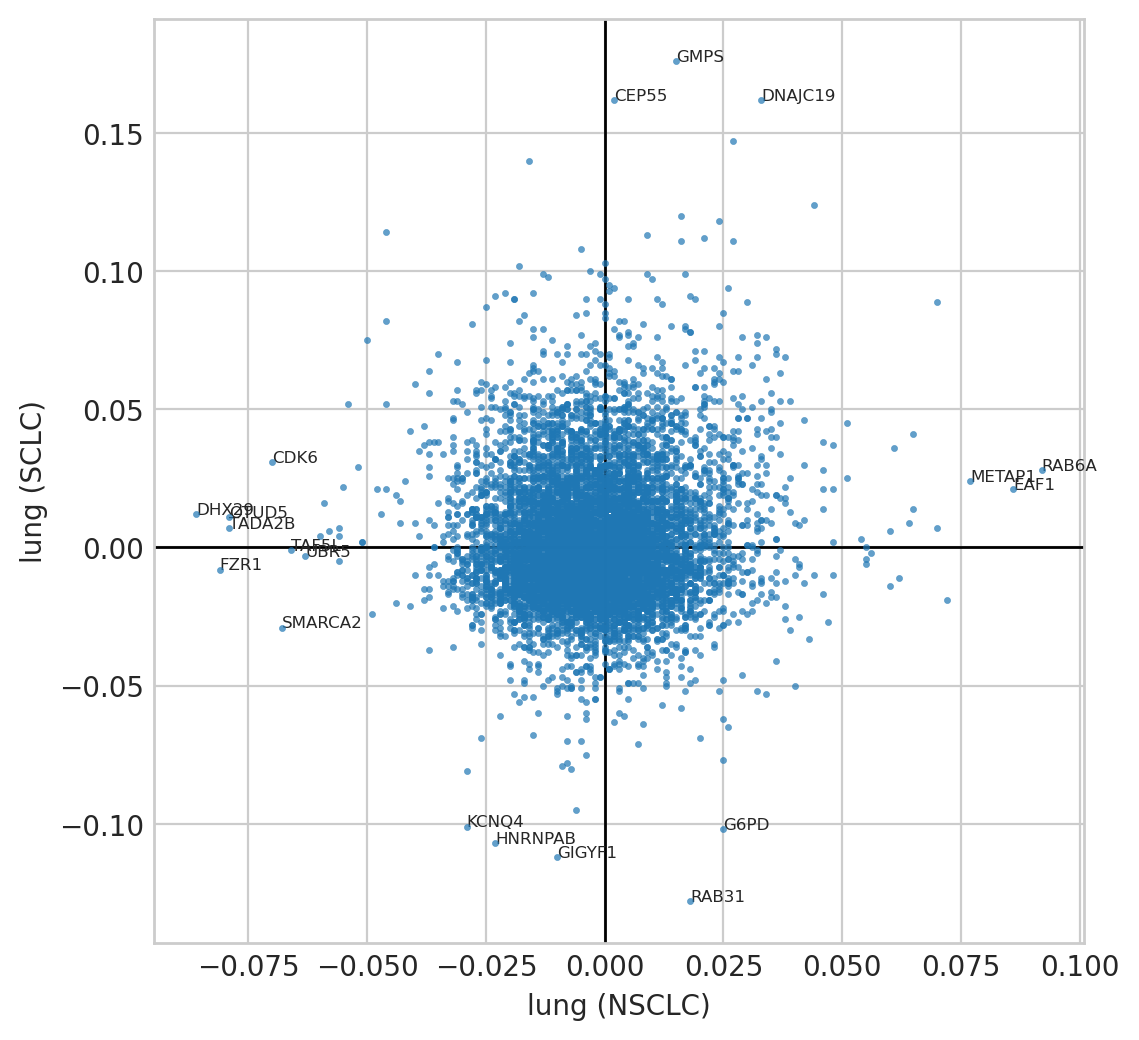

In [41]:
lung_smarca4 = (
    synlet_post.copy()
    .query("cancer_gene == 'SMARCA4'")
    .filter_string("lineage_subtype", "lung")
    .reset_index(drop=True)
)
_genes = lung_smarca4.query("hdi_zero_mu_a")["hugo_symbol"].toset()
df = lung_smarca4.filter_column_isin("hugo_symbol", _genes).pivot_wider(
    "hugo_symbol", names_from="lineage_subtype", values_from="mean_h"
)
_, ax = plt.subplots(figsize=(6, 6))
x, y = "lung (NSCLC)", "lung (SCLC)"
sns.scatterplot(data=df, x=x, y=y, edgecolor=None, s=5, alpha=0.7, ax=ax, zorder=10)
ax.axhline(0, c="k", lw=1, zorder=1)
ax.axvline(0, c="k", lw=1, zorder=1)

hits = df.query(f"`{x}` < -0.06")["hugo_symbol"].tolist()
hits += df.query(f"`{x}` > 0.075")["hugo_symbol"].tolist()
hits += df.query(f"`{y}` < -0.1")["hugo_symbol"].tolist()
hits += df.query(f"`{y}` > 0.15")["hugo_symbol"].tolist()

print(len(hits))
texts = []
for hit in hits:
    d = df.query(f"hugo_symbol == '{hit}'")
    txt = ax.text(d[x].values[0], d[y].values[0], hit, size=6)
    texts.append(txt)

plt.show()

---

In [42]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 2.57 minutes


In [43]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-06

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 3.10.0-1160.76.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-229.o2.rc.hms.harvard.edu

Git branch: figures

json      : 2.0.9
pandas    : 1.4.4
dask      : 2022.9.0
seaborn   : 0.11.2
arviz     : 0.12.1
matplotlib: 3.5.3
numpy     : 1.23.3

